## Data Collection

Daily Data was collecting from 01-01-1990 to 31-12-2023.

Data Source: [open-meteo](https://open-meteo.com/en/docs/historical-weather-api) API

#### API Call

In [3]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
import pandas as pd

In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 'city_latitude',
    "longitude": 'city_longitude',
    "start_date": 'start_date',
    "end_date": 'end_date',
    "daily":  ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant"],
    "timezone": "auto"
}
api_response = openmeteo.weather_api(url, params=params)
response = api_response[0]

In [ ]:
daily = response.Daily()
daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s"),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily.Variables(0).ValuesAsNumpy()
daily_data["temperature_2m_min"] = daily.Variables(1).ValuesAsNumpy()
daily_data["precipitation_sum"] = daily.Variables(2).ValuesAsNumpy()
daily_data["wind_speed_10m_max"] = daily.Variables(3).ValuesAsNumpy()
daily_data["wind_gusts_10m_max"] = daily.Variables(4).ValuesAsNumpy()
daily_data["wind_direction_10m_dominant"] = daily.Variables(5).ValuesAsNumpy()
daily_dataframe = pd.DataFrame(data = daily_data)

In [4]:
daily_dataframe

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2022-12-31 18:30:00,28.549999,21.299999,0.0,13.004921,25.919998,64.204056
1,2023-01-01 18:30:00,28.200001,21.799999,0.1,9.605998,23.759998,84.407700
2,2023-01-02 18:30:00,27.799999,22.000000,0.3,17.709658,36.000000,52.628098
3,2023-01-03 18:30:00,27.600000,22.000000,1.9,16.735161,34.200001,61.804401
4,2023-01-04 18:30:00,28.500000,25.000000,0.0,22.226902,43.199997,60.063496
...,...,...,...,...,...,...,...
361,2023-12-27 18:30:00,28.350000,24.250000,2.0,22.657131,43.560001,34.596729
362,2023-12-28 18:30:00,28.350000,24.250000,2.0,23.863411,45.360001,41.633450
363,2023-12-29 18:30:00,28.299999,23.900000,0.9,18.792549,36.360001,37.787354
364,2023-12-30 18:30:00,28.100000,23.250000,0.2,17.566378,35.639999,44.479641


## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
daily_weather_data = pd.read_csv("../data/1990-2023-data.csv")
daily_weather_data = daily_weather_data.iloc[:, 1:]

In [3]:
daily_weather_data.shape

(211106, 12)

In [4]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211106 entries, 0 to 211105
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         211106 non-null  object 
 1   city_name                    211106 non-null  object 
 2   temperature_2m_max           211106 non-null  float64
 3   temperature_2m_min           211106 non-null  float64
 4   temperature_2m_mean          211106 non-null  float64
 5   precipitation_sum            211106 non-null  float64
 6   precipitation_hours          211106 non-null  int64  
 7   wind_speed_10m_max           211106 non-null  float64
 8   wind_gusts_10m_max           211106 non-null  float64
 9   wind_direction_10m_dominant  211106 non-null  float64
 10  et0_fao_evapotranspiration   211105 non-null  float64
 11  precipitation_forecast       211106 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 19.3+ MB


#### Handling null values

In [5]:
daily_weather_data.isnull().sum()

date                           0
city_name                      0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
precipitation_sum              0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
et0_fao_evapotranspiration     1
precipitation_forecast         0
dtype: int64

In [6]:
daily_weather_data[daily_weather_data["et0_fao_evapotranspiration"].isnull()]

,date,city_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
11767,21-03-2022,Chennai,33.2,27.15,29.5625,0.0,0,14.707222,34.92,125.332726,NaN,0.5


In [7]:
daily_weather_data["et0_fao_evapotranspiration"] = daily_weather_data["et0_fao_evapotranspiration"].fillna(daily_weather_data["et0_fao_evapotranspiration"].mean()).infer_objects(copy=False)

In [8]:
daily_weather_data.describe()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
count,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000
mean,30.451096,24.166130,26.927572,5.021290,6.462914,16.751079,34.778268,212.876876,4.263624,5.022515
std,2.839966,2.240474,2.077805,11.034945,7.989166,5.234025,9.215079,98.861939,1.315122,11.035946
min,19.800000,11.119500,17.177834,0.000000,0.000000,3.259939,10.440001,0.000005,0.414433,0.000000
25%,28.295000,23.147500,25.516413,0.000000,0.000000,13.004921,28.080000,147.181615,3.436586,0.000000
50%,30.150000,24.214500,26.596250,0.500000,2.000000,16.263872,33.839996,236.721500,4.266765,0.500000
75%,32.305500,25.543499,28.250837,5.100000,11.000000,19.995400,39.960000,296.564970,5.145306,5.100001
max,44.839000,34.293500,37.491413,445.199980,24.000000,70.207380,150.480000,360.000000,10.681978,445.199980


##### Rainfall distribution in each month

C:\Users\Asus\AppData\Local\Temp\ipykernel_27640\2027425848.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


<Figure size 800x800 with 0 Axes>

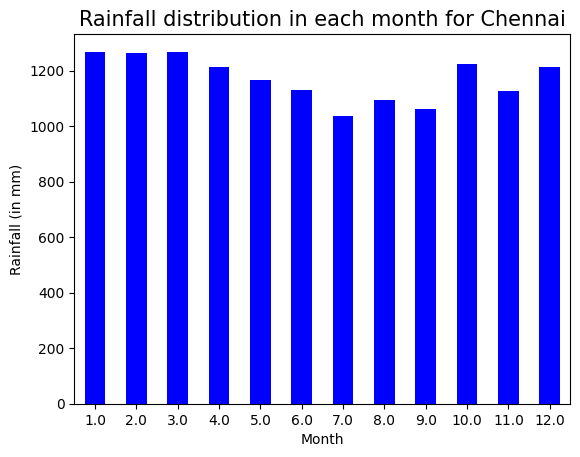

<Figure size 800x800 with 0 Axes>

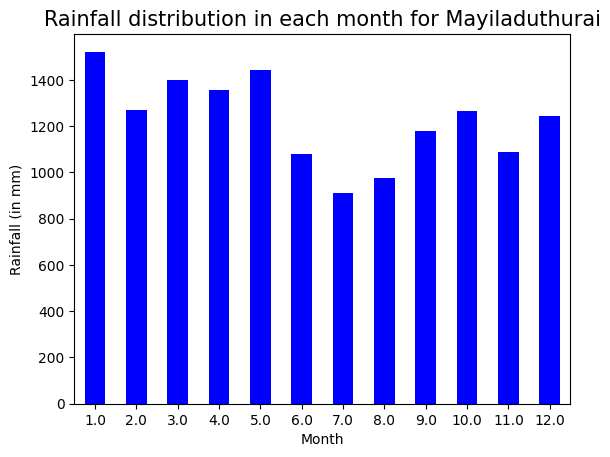

<Figure size 800x800 with 0 Axes>

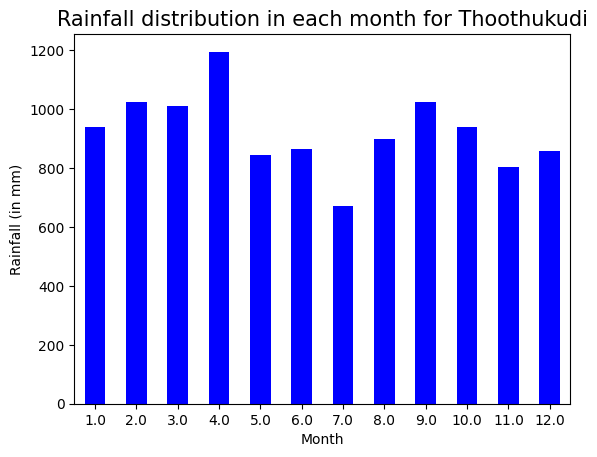

<Figure size 800x800 with 0 Axes>

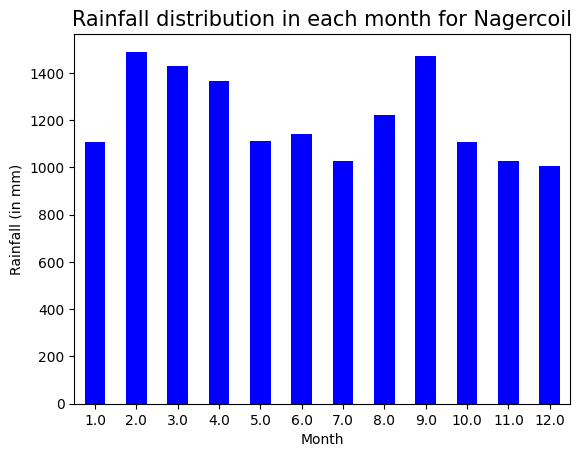

<Figure size 800x800 with 0 Axes>

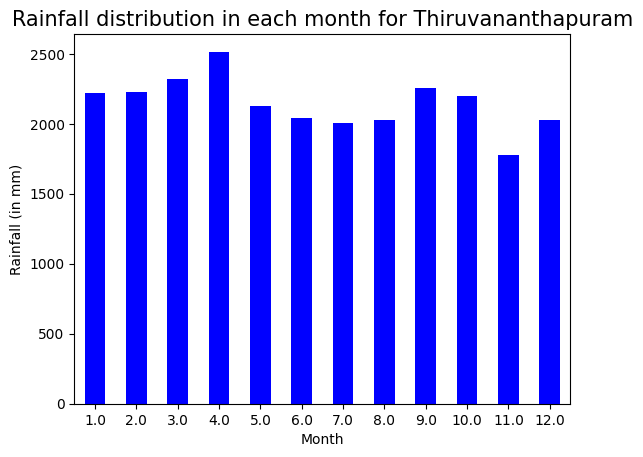

<Figure size 800x800 with 0 Axes>

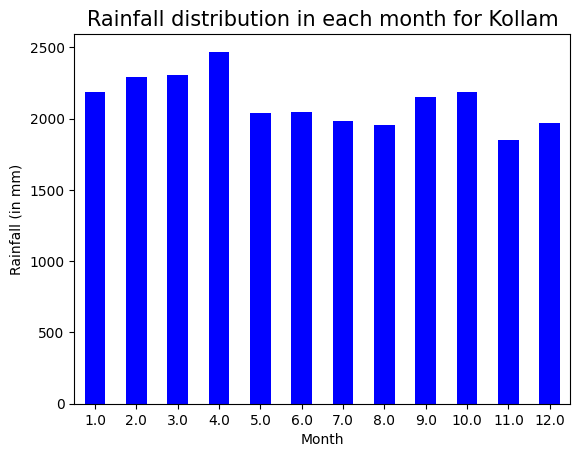

<Figure size 800x800 with 0 Axes>

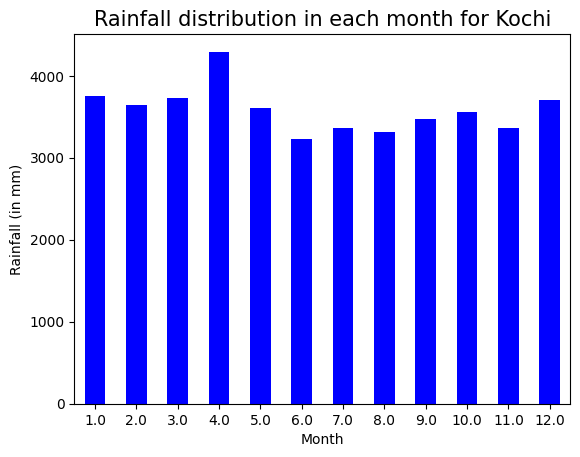

<Figure size 800x800 with 0 Axes>

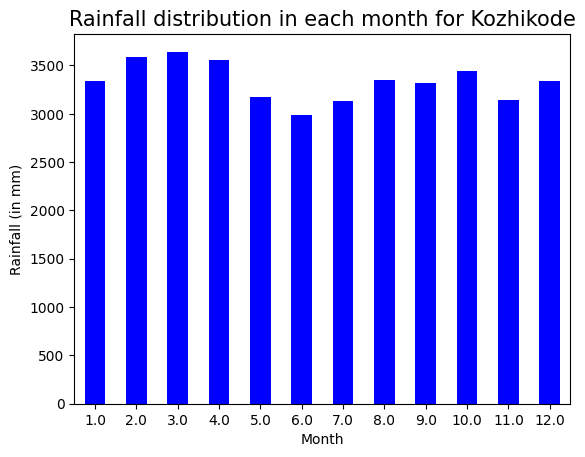

<Figure size 800x800 with 0 Axes>

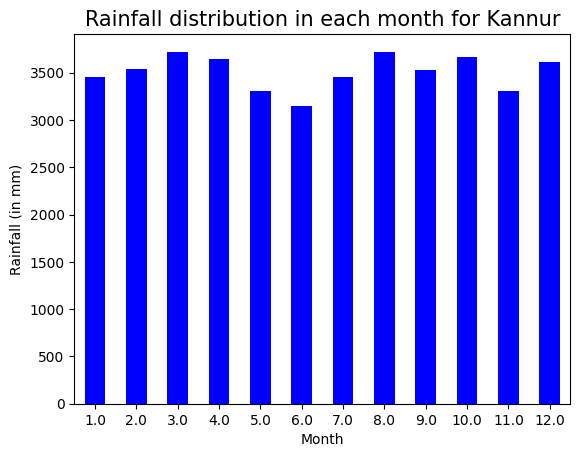

<Figure size 800x800 with 0 Axes>

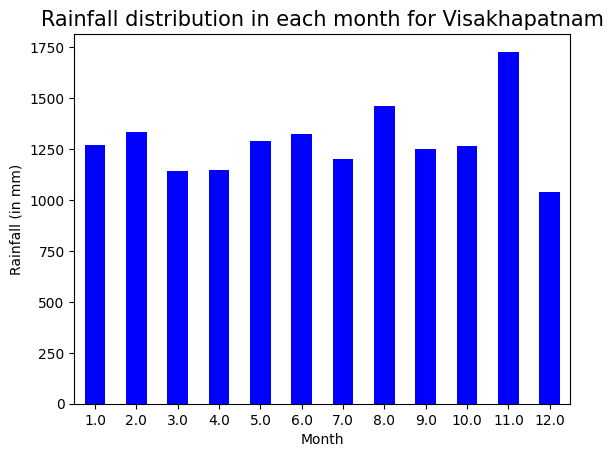

<Figure size 800x800 with 0 Axes>

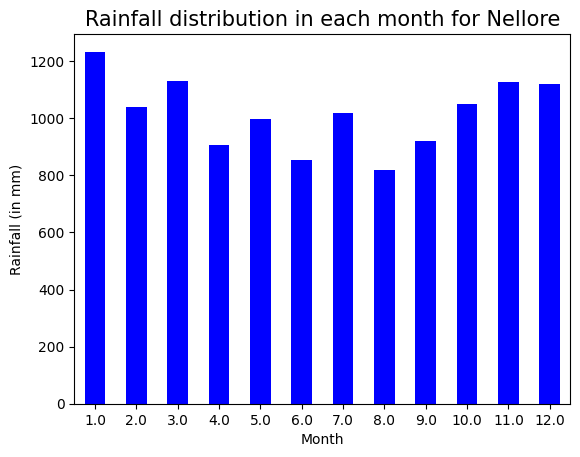

<Figure size 800x800 with 0 Axes>

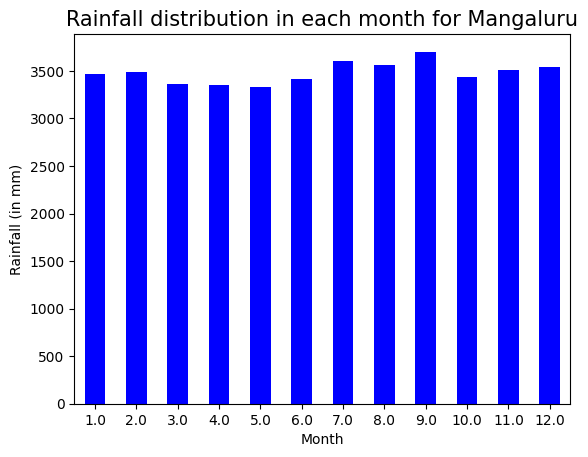

<Figure size 800x800 with 0 Axes>

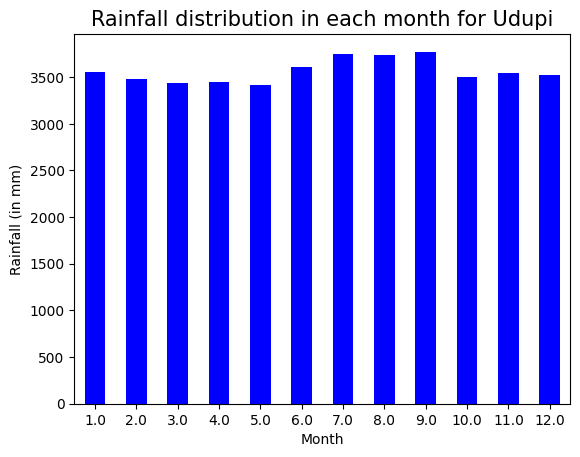

<Figure size 800x800 with 0 Axes>

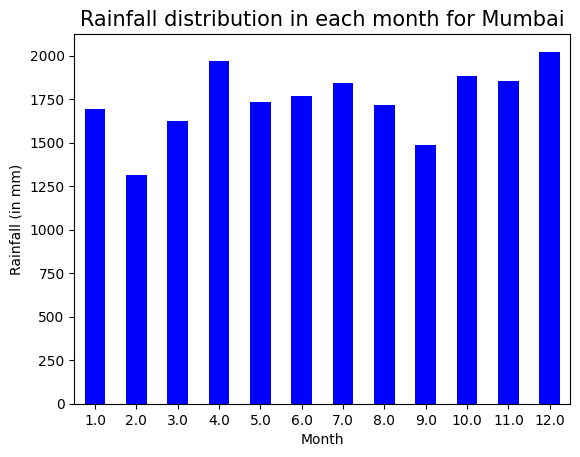

<Figure size 800x800 with 0 Axes>

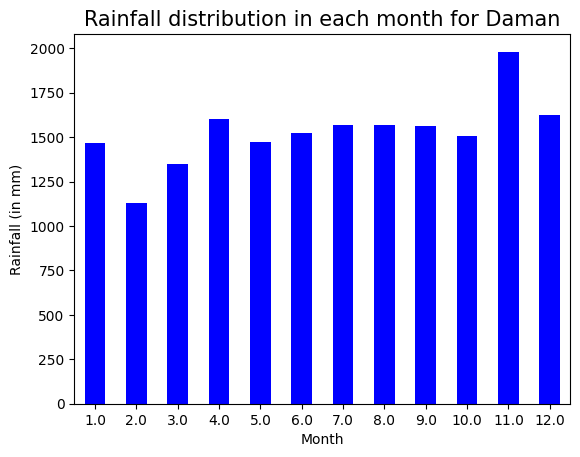

<Figure size 800x800 with 0 Axes>

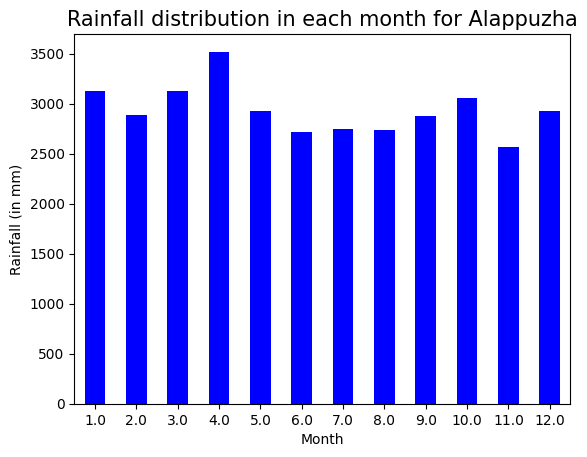

<Figure size 800x800 with 0 Axes>

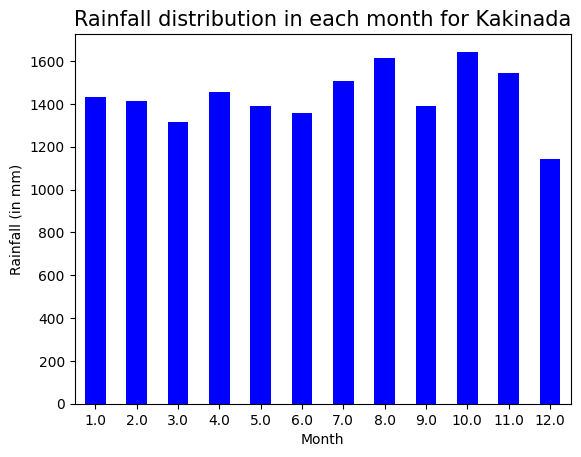

In [20]:
daily_weather_data['date'] = pd.to_datetime(daily_weather_data['date'], errors='coerce')
cities = daily_weather_data['city_name'].unique()

for city in cities:
    city_data = daily_weather_data[daily_weather_data['city_name'] == city]
    rainfall = [city_data['date'].dt.year, city_data['date'].dt.month, city_data['precipitation_forecast']]
    headers = ['Year', 'Month', 'Precipitation']
    rainfall_df = pd.concat(rainfall, axis=1, keys=headers)

    plt.figure(figsize=(8, 8))
    a = rainfall_df.groupby('Month').agg({'Precipitation': 'sum'})
    a.plot(kind='bar', color='blue', legend=False)

    plt.title(f'Rainfall distribution in each month for {city}', fontsize=15)
    plt.xlabel('Month', fontsize=10)
    plt.ylabel('Rainfall (in mm)', fontsize=10)
    plt.xticks(rotation=0)

plt.show()


##### Correlation between attributes

<Axes: >

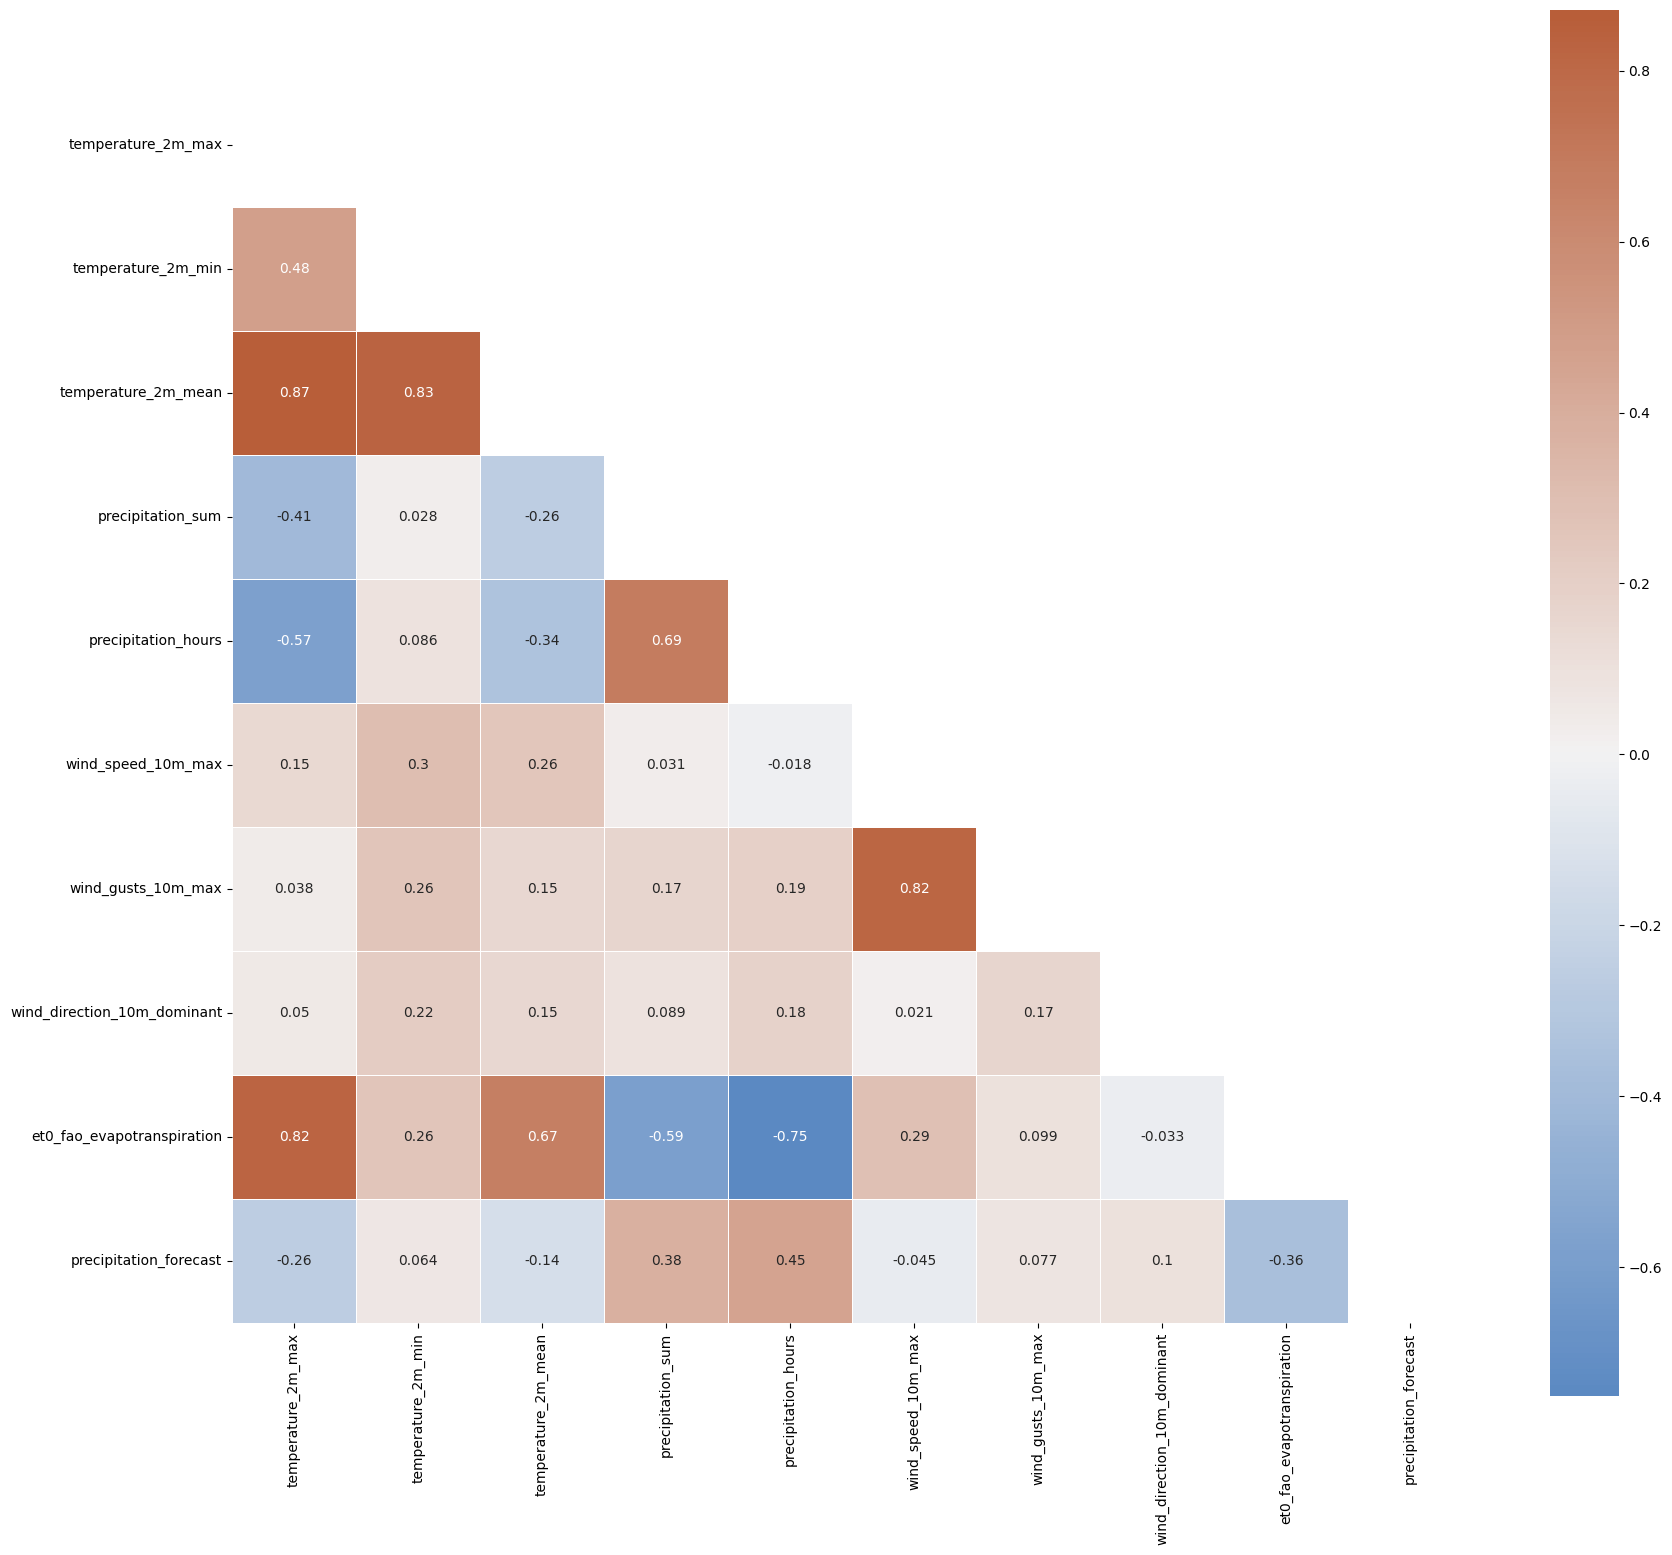

In [22]:
corr = daily_weather_data.iloc[:, 2:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax =plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=None, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.9})

##### Rainfall vs City plot 

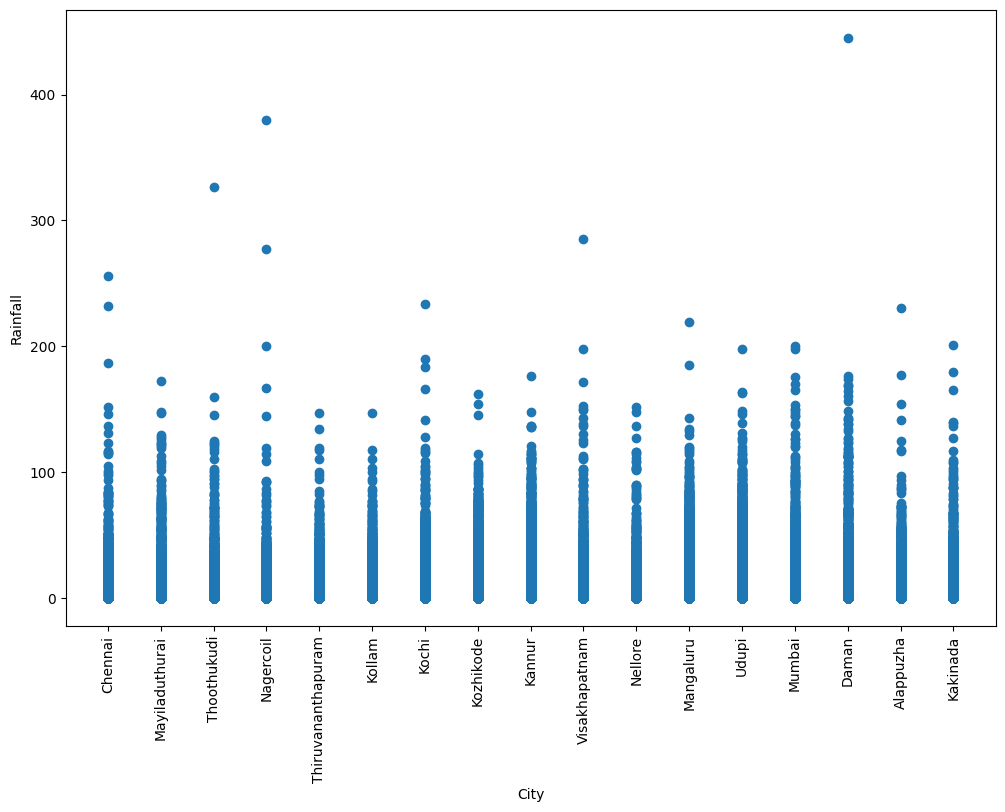

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(daily_weather_data['city_name'], daily_weather_data["precipitation_sum"])
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Rainfall")
plt.show()

#### Encoding

In [9]:
daily_weather_data.select_dtypes(include=["object"]).columns

Index(['date', 'city_name'], dtype='object')

City name encoding

In [10]:
#OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
city_names = daily_weather_data['city_name'].values.reshape(-1, 1)
cityEncoder = OneHotEncoder(sparse_output=False)
cityEncoded = cityEncoder.fit_transform(city_names)

In [11]:
cityEncoded_df = pd.DataFrame(cityEncoded, columns=cityEncoder.categories_[0])
daily_weather_data = pd.concat([daily_weather_data, cityEncoded_df], axis=1)
daily_weather_data.drop('city_name', axis=1, inplace=True)

In [12]:
daily_weather_data.head(1)

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,...,Kozhikode,Mangaluru,Mayiladuthurai,Mumbai,Nagercoil,Nellore,Thiruvananthapuram,Thoothukudi,Udupi,Visakhapatnam
0,01-01-1990,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Date encoding (Cyclical Encoding)

In [13]:
def date_encoder(dataset):
    dataset['date'] = pd.to_datetime(dataset['date'], format='%d-%m-%Y')
    df_encode = dataset.copy()
    df_encode['day_of_year'] = df_encode['date'].dt.dayofyear
    for i in df_encode['day_of_year']:
        df_encode['day_of_year_sin'] = np.sin(2 * np.pi * i / 366)
        df_encode['day_of_year_cos'] = np.cos(2 * np.pi * i / 366)
    dataset = pd.concat([dataset['city_name'], df_encode[['day_of_year_sin', 'day_of_year_cos']],
                    dataset[['temperature_2m_max','temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum','precipitation_hours','wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant','et0_fao_evapotranspiration','precipitation_forecast']]], axis=1)
    return dataset

In [14]:
daily_weather_data.head(1)

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,...,Kozhikode,Mangaluru,Mayiladuthurai,Mumbai,Nagercoil,Nellore,Thiruvananthapuram,Thoothukudi,Udupi,Visakhapatnam
0,01-01-1990,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
daily_weather_data = date_encoder(daily_weather_data)

KeyError: 'city_name'

In [ ]:
daily_weather_data.head(1)

,city_name,day_of_year_sin,day_of_year_cos,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
0,Chennai,-0.017166,0.999853,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,0.0


### Train Test split

In [45]:
features = daily_weather_data.drop(columns="precipitation_forecast")

target = daily_weather_data[["precipitation_forecast"]]

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123)

In [89]:
len(X_train), len(X_test), len(y_train), len(y_test)

(168884, 42222, 168884, 42222)

In [90]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [91]:
X_train = X_train.to_numpy(dtype=float)
y_train = y_train.to_numpy(dtype=float)
X_test = X_test.to_numpy(dtype=float)
y_test = y_test.to_numpy(dtype=float)

### Feature Scaling

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
#scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train)
#y_test = scaler_y.transform(y_test)

In [93]:
X_train

array([[ 6.93889390e-18,  4.44089210e-16, -2.83921360e-01, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16,  7.54408147e-02, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16, -9.76045861e-01, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       ...,
       [ 6.93889390e-18,  4.44089210e-16,  8.29219534e-01, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16,  3.51127973e-01, ...,
         4.00071739e+00, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16, -1.30229034e+00, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01]])

In [94]:
X_test

array([[ 6.93889390e-18,  4.44089210e-16, -1.36829489e-01, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16,  1.96561644e+00, ...,
        -2.49955171e-01, -2.50302629e-01,  4.00436014e+00],
       [ 6.93889390e-18,  4.44089210e-16,  3.89706912e-01, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       ...,
       [ 6.93889390e-18,  4.44089210e-16,  1.15846046e+00, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16,  1.40895633e+00, ...,
         4.00071739e+00, -2.50302629e-01, -2.49727788e-01],
       [ 6.93889390e-18,  4.44089210e-16,  1.44418792e+00, ...,
        -2.49955171e-01, -2.50302629e-01, -2.49727788e-01]])

### Model Selection

Mutli Linear Regression

In [95]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [96]:
y_pred = regressor.predict(X_test)
y_pred

array([[1.85525013],
       [3.11086537],
       [2.50295521],
       ...,
       [6.3598888 ],
       [2.76842762],
       [0.30175282]])

In [97]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

92.50927185359048

 Ridge Regression

In [98]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.3)
ridge.fit(X_train, y_train)

Ridge(alpha=0.3)

In [99]:
y_pred = ridge.predict(X_test)
y_pred

array([[1.88832807],
       [3.0863965 ],
       [2.48075272],
       ...,
       [6.36617579],
       [2.73212802],
       [0.34126989]])

In [100]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

92.5093256294877

 Lasso Regression

In [85]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [86]:
y_pred = reg.predict(X_test)
y_pred

array([2.34162543, 2.83983943, 1.73123628, ..., 5.60190562, 2.68051984,
       0.59943459])

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

92.88176920257361

 SVR

In [88]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

d:\Final Project\Model-API\env\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [89]:
y_pred = svr_rbf.predict(X_test)
y_pred

array([ 0.64584594,  0.88964334, -0.0280272 , ...,  2.91720007,
        0.2033091 ,  0.0336987 ])

In [90]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

96.69406030324963

## Saving Model

In [92]:
import joblib
joblib.dump(cityEncoder, "MLModel\CityEncoder_2.pkl")
joblib.dump(scaler, "MLModel\StandardScaler_2.pkl")
joblib.dump(regressor, "MLModel\MLR_2.pkl")

['MLModel\\MLR_2.pkl']

# PyTorch

In [57]:
import torch
from torch import nn

In [80]:
X_train = torch.from_numpy(X_train).type(dtype=torch.float)
X_test = torch.from_numpy(X_test).type(dtype=torch.float)
y_train = torch.from_numpy(y_train).type(dtype=torch.float)
y_test = torch.from_numpy(y_test).type(dtype=torch.float)

In [82]:
len(X_train[0]), len(y_train[0])

(28, 1)

In [101]:
class RainfallModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.block_1(x)

model_0 = RainfallModelV0(28, 8, 1)
model_0

RainfallModelV0(
  (block_1): Sequential(
    (0): Linear(in_features=28, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [102]:
model_0.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[-0.0274,  0.1517, -0.0471,  0.1139, -0.1568, -0.1855,  0.0544, -0.1830,
                       -0.1664, -0.0875,  0.0640,  0.0676,  0.0706,  0.1412,  0.1368,  0.0640,
                       -0.0775,  0.0005,  0.0735, -0.0712, -0.0092,  0.0276,  0.0311,  0.1339,
                        0.1764,  0.0926,  0.0246,  0.0109],
                      [ 0.1455,  0.1144, -0.1588, -0.1367,  0.0673,  0.1366, -0.0259,  0.0442,
                       -0.1850,  0.0491, -0.1778, -0.1283, -0.1835,  0.1258,  0.1425, -0.1863,
                       -0.0050,  0.1833, -0.1633, -0.0151,  0.0739,  0.1123, -0.0128, -0.0335,
                       -0.1355, -0.0024,  0.1788, -0.0044],
                      [ 0.0169,  0.0107,  0.1170, -0.1810, -0.0291,  0.1887,  0.0485, -0.1881,
                       -0.1310,  0.1687, -0.0913, -0.0786,  0.0788,  0.0195, -0.0025, -0.1055,
                        0.0617,  0.0793,  0.0343,  0.0601, -0.1408, -0.0337,  0.0551, 

In [103]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [104]:
EPOCH = 1000

for epoch in range(EPOCH+1):
    model_0.train()

    y_pred = model_0(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(X_test)

        test_loss = loss_fn(y_test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 150.24728393554688 | Test loss: 124.57707214355469
Epoch: 50 | Train loss: 94.90373229980469 | Test loss: 96.18238067626953
Epoch: 100 | Train loss: 95.180908203125 | Test loss: 95.46729278564453
Epoch: 150 | Train loss: 95.02751922607422 | Test loss: 94.58446502685547
Epoch: 200 | Train loss: 94.8603515625 | Test loss: 94.06136322021484
Epoch: 250 | Train loss: 94.56044006347656 | Test loss: 93.5645523071289
Epoch: 300 | Train loss: 94.23615264892578 | Test loss: 93.1175308227539
Epoch: 350 | Train loss: 93.91472625732422 | Test loss: 92.76058959960938
Epoch: 400 | Train loss: 93.90835571289062 | Test loss: 92.63007354736328
Epoch: 450 | Train loss: 93.80073547363281 | Test loss: 92.4587173461914
Epoch: 500 | Train loss: 93.72832489013672 | Test loss: 92.33527374267578
Epoch: 550 | Train loss: 93.54035949707031 | Test loss: 92.1544418334961
Epoch: 600 | Train loss: 93.51913452148438 | Test loss: 92.07403564453125
Epoch: 650 | Train loss: 93.45875549316406 | Test